In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [17]:
# Transforms are applied to each image. Some are mandatory, like conversion to Tensor and 
# Normalize the image. Others are optional and used for data augmentation (like random crop, 
# random jitter etc.)

transform = transforms.Compose([transforms.ToTensor(), 
                                # Various transforms can be added in this pipeline for data augmentation
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [18]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


Files already downloaded and verified


In [19]:
len(trainset.train_data)


50000

9


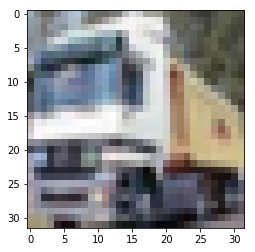

In [20]:
plt.imshow(trainset.train_data[1])
print(trainset.train_labels[1])

In [21]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=10, shuffle=True,num_workers=2)

In [22]:
for i, data in enumerate(trainloader):
    data, labels = data
    
    print('Iteration',i)
    print("")
    print("type(data):",type(data))
    print("data.size():",data.size())
    print("")
    print("type(labels): ",type(labels))
    print("label.size()")
    
    
    if i == 3:
        break
    
    
    
    

Iteration 0

type(data): <class 'torch.Tensor'>
data.size(): torch.Size([10, 3, 32, 32])

type(labels):  <class 'torch.Tensor'>
label.size()
Iteration 1

type(data): <class 'torch.Tensor'>
data.size(): torch.Size([10, 3, 32, 32])

type(labels):  <class 'torch.Tensor'>
label.size()
Iteration 2

type(data): <class 'torch.Tensor'>
data.size(): torch.Size([10, 3, 32, 32])

type(labels):  <class 'torch.Tensor'>
label.size()
Iteration 3

type(data): <class 'torch.Tensor'>
data.size(): torch.Size([10, 3, 32, 32])

type(labels):  <class 'torch.Tensor'>
label.size()


# Deep Learning with Pytorch

In [23]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 

from torch.autograd import Variable

#Custom DataSet
# from data import iris 
# import datasets

In [24]:
import numpy as np
import pandas as pd
from torch.utils.data.dataset import Dataset


label_idx = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}


class IrisDataset(Dataset):

    def __init__(self, data):
        self.data = data
           
    def __getitem__(self, index):
        item = self.data.iloc[index].values
        return (item[0:4].astype(np.float32), item[4].astype(np.int))

    def __len__(self):
        return self.data.shape[0]


def get_datasets(iris_file, train_ratio=0.80):

    labels = {'class': label_idx}
    data = pd.read_csv(iris_file)
    data.replace(labels, inplace=True)

    train_df = data.sample(frac=train_ratio, random_state=3)
    test_df = data.loc[~data.index.isin(train_df.index), :]

    return IrisDataset(train_df), IrisDataset(test_df)

In [25]:
class IrisNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [26]:
model = IrisNet(4,100,50,3)
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


In [27]:
iris_data_file = '../input/deep-learning-with-pytorch/iris.data.txt'
train_ds, test_ds =get_datasets(iris_data_file)


## Create DataLoader

In [28]:
batch_size = 60

print('# instances in training set: ', len(train_ds))
print('# instances in testing/validation set: ', len(test_ds))
# Create the dataloaders - for training and validation/testing
# We will be using the term validation and testing data interchangably
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

# instances in training set:  120
# instances in testing/validation set:  30


In [29]:

# Our model
net = IrisNet(4, 100, 50, 3)

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)

In [33]:
num_epochs = 500

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(items)  # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data
        train_total += classes.size(0)    
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, i+1, len(train_ds)//batch_size, loss.item()))

    net.eval()                 # Put the network into evaluation mode
    
    # Book keeping
    # Record the loss
    train_loss.append(loss.item())

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_items = torch.FloatTensor(test_ds.data.values[:, 0:4])
    test_classes = torch.LongTensor(test_ds.data.values[:, 4])

    outputs = net(Variable(test_items))
    loss = criterion(outputs, Variable(test_classes))
    test_loss.append(loss.item())
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes).sum()
    test_accuracy.append((100 * correct / total))

Epoch 1/500, Iteration 1/2, Loss: 1.1250
Epoch 1/500, Iteration 2/2, Loss: 1.0355
Epoch 2/500, Iteration 1/2, Loss: 1.0702
Epoch 2/500, Iteration 2/2, Loss: 1.0161
Epoch 3/500, Iteration 1/2, Loss: 1.0248
Epoch 3/500, Iteration 2/2, Loss: 1.0033
Epoch 4/500, Iteration 1/2, Loss: 0.9922
Epoch 4/500, Iteration 2/2, Loss: 0.9902
Epoch 5/500, Iteration 1/2, Loss: 0.9806
Epoch 5/500, Iteration 2/2, Loss: 0.9698
Epoch 6/500, Iteration 1/2, Loss: 0.9599
Epoch 6/500, Iteration 2/2, Loss: 0.9616
Epoch 7/500, Iteration 1/2, Loss: 0.9559
Epoch 7/500, Iteration 2/2, Loss: 0.9438
Epoch 8/500, Iteration 1/2, Loss: 0.9327
Epoch 8/500, Iteration 2/2, Loss: 0.9486
Epoch 9/500, Iteration 1/2, Loss: 0.9231
Epoch 9/500, Iteration 2/2, Loss: 0.9370
Epoch 10/500, Iteration 1/2, Loss: 0.9103
Epoch 10/500, Iteration 2/2, Loss: 0.9280
Epoch 11/500, Iteration 1/2, Loss: 0.9094
Epoch 11/500, Iteration 2/2, Loss: 0.9050
Epoch 12/500, Iteration 1/2, Loss: 0.8988
Epoch 12/500, Iteration 2/2, Loss: 0.8894
Epoch 13/5

Epoch 103/500, Iteration 1/2, Loss: 0.4101
Epoch 103/500, Iteration 2/2, Loss: 0.3695
Epoch 104/500, Iteration 1/2, Loss: 0.3952
Epoch 104/500, Iteration 2/2, Loss: 0.3802
Epoch 105/500, Iteration 1/2, Loss: 0.3915
Epoch 105/500, Iteration 2/2, Loss: 0.3809
Epoch 106/500, Iteration 1/2, Loss: 0.3835
Epoch 106/500, Iteration 2/2, Loss: 0.3834
Epoch 107/500, Iteration 1/2, Loss: 0.3722
Epoch 107/500, Iteration 2/2, Loss: 0.3913
Epoch 108/500, Iteration 1/2, Loss: 0.3811
Epoch 108/500, Iteration 2/2, Loss: 0.3782
Epoch 109/500, Iteration 1/2, Loss: 0.3681
Epoch 109/500, Iteration 2/2, Loss: 0.3875
Epoch 110/500, Iteration 1/2, Loss: 0.3651
Epoch 110/500, Iteration 2/2, Loss: 0.3865
Epoch 111/500, Iteration 1/2, Loss: 0.3326
Epoch 111/500, Iteration 2/2, Loss: 0.4149
Epoch 112/500, Iteration 1/2, Loss: 0.3883
Epoch 112/500, Iteration 2/2, Loss: 0.3554
Epoch 113/500, Iteration 1/2, Loss: 0.3650
Epoch 113/500, Iteration 2/2, Loss: 0.3744
Epoch 114/500, Iteration 1/2, Loss: 0.3569
Epoch 114/5

Epoch 204/500, Iteration 2/2, Loss: 0.2227
Epoch 205/500, Iteration 1/2, Loss: 0.2448
Epoch 205/500, Iteration 2/2, Loss: 0.2122
Epoch 206/500, Iteration 1/2, Loss: 0.2442
Epoch 206/500, Iteration 2/2, Loss: 0.2111
Epoch 207/500, Iteration 1/2, Loss: 0.1832
Epoch 207/500, Iteration 2/2, Loss: 0.2688
Epoch 208/500, Iteration 1/2, Loss: 0.2358
Epoch 208/500, Iteration 2/2, Loss: 0.2157
Epoch 209/500, Iteration 1/2, Loss: 0.2011
Epoch 209/500, Iteration 2/2, Loss: 0.2475
Epoch 210/500, Iteration 1/2, Loss: 0.2411
Epoch 210/500, Iteration 2/2, Loss: 0.2054
Epoch 211/500, Iteration 1/2, Loss: 0.2325
Epoch 211/500, Iteration 2/2, Loss: 0.2113
Epoch 212/500, Iteration 1/2, Loss: 0.2222
Epoch 212/500, Iteration 2/2, Loss: 0.2194
Epoch 213/500, Iteration 1/2, Loss: 0.2103
Epoch 213/500, Iteration 2/2, Loss: 0.2289
Epoch 214/500, Iteration 1/2, Loss: 0.2473
Epoch 214/500, Iteration 2/2, Loss: 0.1899
Epoch 215/500, Iteration 1/2, Loss: 0.2154
Epoch 215/500, Iteration 2/2, Loss: 0.2206
Epoch 216/5

Epoch 304/500, Iteration 2/2, Loss: 0.1422
Epoch 305/500, Iteration 1/2, Loss: 0.1229
Epoch 305/500, Iteration 2/2, Loss: 0.1770
Epoch 306/500, Iteration 1/2, Loss: 0.1407
Epoch 306/500, Iteration 2/2, Loss: 0.1588
Epoch 307/500, Iteration 1/2, Loss: 0.1566
Epoch 307/500, Iteration 2/2, Loss: 0.1419
Epoch 308/500, Iteration 1/2, Loss: 0.1030
Epoch 308/500, Iteration 2/2, Loss: 0.1938
Epoch 309/500, Iteration 1/2, Loss: 0.1663
Epoch 309/500, Iteration 2/2, Loss: 0.1297
Epoch 310/500, Iteration 1/2, Loss: 0.1724
Epoch 310/500, Iteration 2/2, Loss: 0.1225
Epoch 311/500, Iteration 1/2, Loss: 0.1509
Epoch 311/500, Iteration 2/2, Loss: 0.1437
Epoch 312/500, Iteration 1/2, Loss: 0.1487
Epoch 312/500, Iteration 2/2, Loss: 0.1445
Epoch 313/500, Iteration 1/2, Loss: 0.1532
Epoch 313/500, Iteration 2/2, Loss: 0.1390
Epoch 314/500, Iteration 1/2, Loss: 0.1433
Epoch 314/500, Iteration 2/2, Loss: 0.1482
Epoch 315/500, Iteration 1/2, Loss: 0.1495
Epoch 315/500, Iteration 2/2, Loss: 0.1406
Epoch 316/5

Epoch 404/500, Iteration 1/2, Loss: 0.1562
Epoch 404/500, Iteration 2/2, Loss: 0.0736
Epoch 405/500, Iteration 1/2, Loss: 0.1000
Epoch 405/500, Iteration 2/2, Loss: 0.1339
Epoch 406/500, Iteration 1/2, Loss: 0.1062
Epoch 406/500, Iteration 2/2, Loss: 0.1230
Epoch 407/500, Iteration 1/2, Loss: 0.1382
Epoch 407/500, Iteration 2/2, Loss: 0.0893
Epoch 408/500, Iteration 1/2, Loss: 0.0990
Epoch 408/500, Iteration 2/2, Loss: 0.1283
Epoch 409/500, Iteration 1/2, Loss: 0.1327
Epoch 409/500, Iteration 2/2, Loss: 0.0939
Epoch 410/500, Iteration 1/2, Loss: 0.1017
Epoch 410/500, Iteration 2/2, Loss: 0.1242
Epoch 411/500, Iteration 1/2, Loss: 0.1043
Epoch 411/500, Iteration 2/2, Loss: 0.1212
Epoch 412/500, Iteration 1/2, Loss: 0.0804
Epoch 412/500, Iteration 2/2, Loss: 0.1450
Epoch 413/500, Iteration 1/2, Loss: 0.1066
Epoch 413/500, Iteration 2/2, Loss: 0.1219
Epoch 414/500, Iteration 1/2, Loss: 0.1142
Epoch 414/500, Iteration 2/2, Loss: 0.1098
Epoch 415/500, Iteration 1/2, Loss: 0.0983
Epoch 415/5

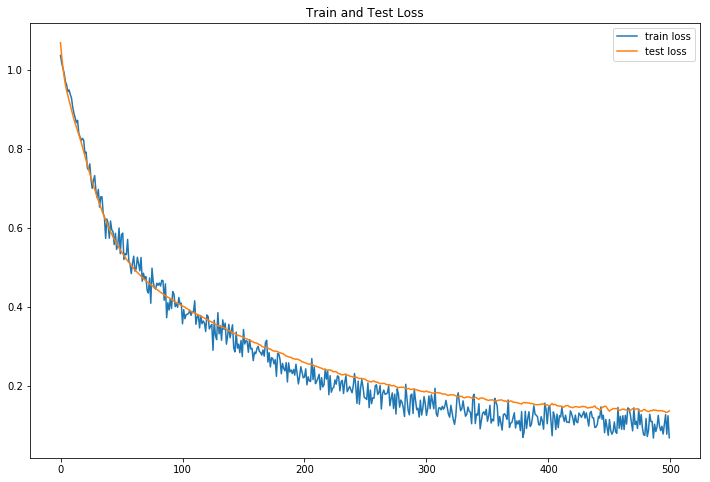

In [34]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

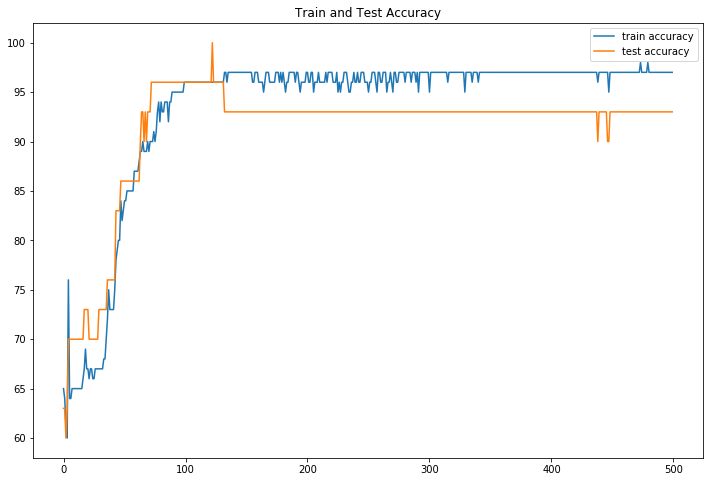

In [35]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show()

# Saving the model to disk, and loading it back

In [36]:
torch.save(net.state_dict(), "./2.model.pth")


In [37]:
net2 = IrisNet(4, 100, 50, 3)
net2.load_state_dict(torch.load("./2.model.pth"))


In [38]:
output = net2(Variable(torch.FloatTensor([[5.1, 3.5, 1.4, 0.2]])))


In [39]:
_, predicted_class = torch.max(output.data, 1)
print('Predicted class: ', predicted_class.numpy()[0])
print('Expected class: ', 0 )

Predicted class:  0
Expected class:  0
